In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sat Feb 10 17:23:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 32%   53C    P0              92W / 450W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_wise_min_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 1024
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 13.992919921875
encoder.convs 5.989013671875
encoder.linear 8.00390625
prior 0.0
latent 0.0
decoder 14.028697967529297
decoder.linear 8.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.10-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 106172
-rw-rw-r-- 1 scpark scpark  1801402  2월 10 17:23 events.out.tfevents.1707552605.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 50467924  2월 10 17:20 save_10000
-rw-rw-r-- 1 scpark scpark 50462060  2월 10 17:10 save_0
-rw-rw-r-- 1 scpark scpark   354406  2월 10 17:10 events.out.tfevents.1707552467.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark   773986  2월 10 17:07 events.out.tfevents.1707552069.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark   248142  2월 10 17:01 events.out.tfevents.1707551933.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark  1941558  2월 10 16:26 events.out.tfevents.1707548784.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark   956322  2월 10 16:06 events.out.tfevents.1707548326.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark  1135846  2월 10 15:58 events.out.tfevents.1707547756.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark   550358  2월 10 15:49 events.out.tfevents.1707547480.scpark-X299-WU8


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


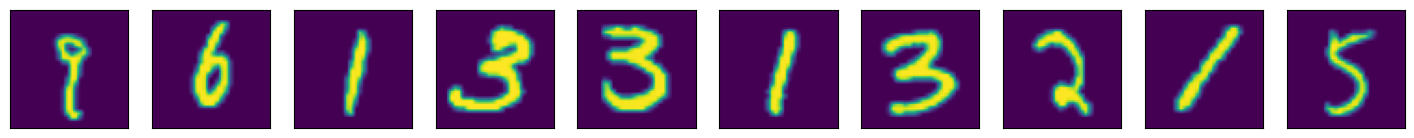

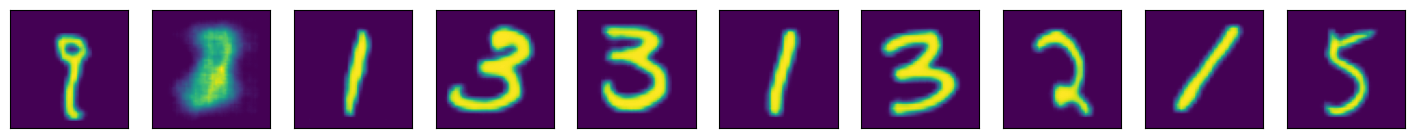

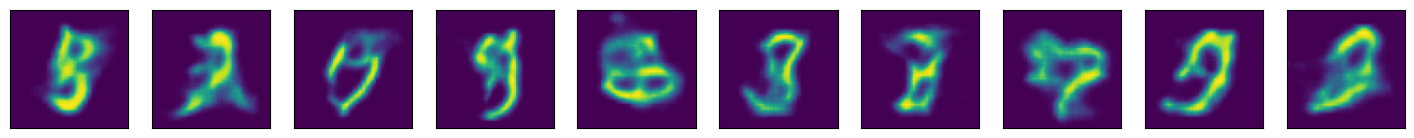

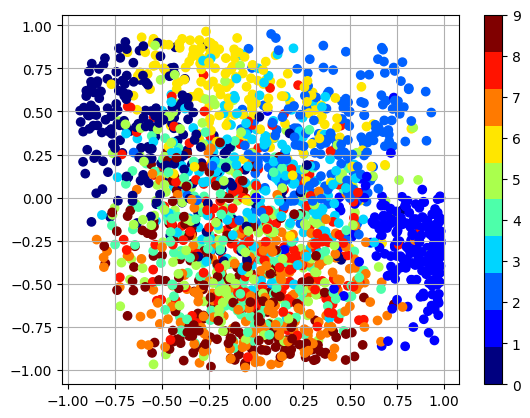

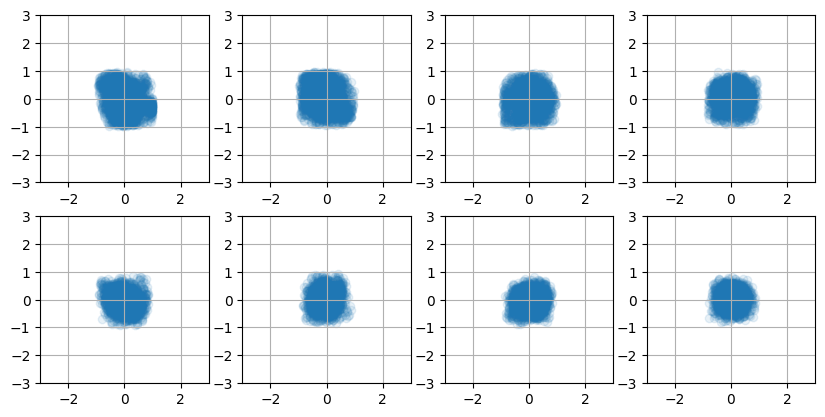

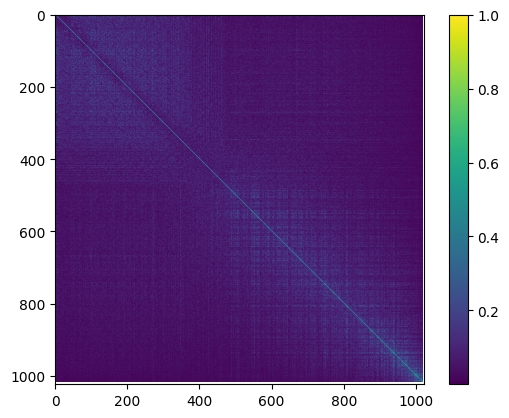

9001
min_loss 357.793212890625
wise_min_loss 0.10571307688951492
recon_loss 0.007398345973342657
9002
min_loss 358.50946044921875
wise_min_loss 0.10582353174686432
recon_loss 0.006798301823437214
9003
min_loss 358.64910888671875
wise_min_loss 0.10651159286499023
recon_loss 0.00463904021307826
9004
min_loss 361.0047302246094
wise_min_loss 0.10373172163963318
recon_loss 0.006446678191423416
9005
min_loss 357.8453063964844
wise_min_loss 0.10658964514732361
recon_loss 0.007131841033697128
9006
min_loss 359.44964599609375
wise_min_loss 0.10529131442308426
recon_loss 0.0054853083565831184
9007
min_loss 359.14715576171875
wise_min_loss 0.1057160273194313
recon_loss 0.004181058146059513
9008
min_loss 359.1703186035156
wise_min_loss 0.10569150745868683
recon_loss 0.005624111276119947
9009
min_loss 355.9617614746094
wise_min_loss 0.11115401983261108
recon_loss 0.003919385373592377
9010
min_loss 359.8057861328125
wise_min_loss 0.1069180890917778
recon_loss 0.004930752795189619
9011
min_loss 355.6

min_loss 359.01861572265625
wise_min_loss 0.10790657997131348
recon_loss 0.005555801093578339
9087
min_loss 358.8019104003906
wise_min_loss 0.11097382009029388
recon_loss 0.004544462077319622
9088
min_loss 357.5791015625
wise_min_loss 0.11124731600284576
recon_loss 0.004238573834300041
9089
min_loss 359.0649108886719
wise_min_loss 0.11028893291950226
recon_loss 0.0041359663009643555
9090
min_loss 357.6810607910156
wise_min_loss 0.11032180488109589
recon_loss 0.007192840799689293
9091
min_loss 359.261962890625
wise_min_loss 0.10978035628795624
recon_loss 0.007141876965761185
9092
min_loss 358.0904541015625
wise_min_loss 0.11182817071676254
recon_loss 0.005015771370381117
9093
min_loss 358.03839111328125
wise_min_loss 0.10964131355285645
recon_loss 0.004662185441702604
9094
min_loss 358.75396728515625
wise_min_loss 0.11062870919704437
recon_loss 0.005403660237789154
9095
min_loss 356.86798095703125
wise_min_loss 0.10968534648418427
recon_loss 0.004222711082547903
9096
min_loss 357.864105

9172
min_loss 356.895751953125
wise_min_loss 0.11180849373340607
recon_loss 0.005604950245469809
9173
min_loss 356.3165283203125
wise_min_loss 0.11196942627429962
recon_loss 0.006207933183759451
9174
min_loss 356.71990966796875
wise_min_loss 0.10993914306163788
recon_loss 0.00442105159163475
9175
min_loss 356.5892639160156
wise_min_loss 0.1120276153087616
recon_loss 0.004943772219121456
9176
min_loss 356.3705749511719
wise_min_loss 0.113440603017807
recon_loss 0.004387288819998503
9177
min_loss 357.07061767578125
wise_min_loss 0.11058435589075089
recon_loss 0.0061021000146865845
9178
min_loss 359.67437744140625
wise_min_loss 0.10761886835098267
recon_loss 0.00433544022962451
9179
min_loss 357.45263671875
wise_min_loss 0.11102841794490814
recon_loss 0.007008684799075127
9180
min_loss 355.570068359375
wise_min_loss 0.11403241753578186
recon_loss 0.005448433570563793
9181
min_loss 355.886962890625
wise_min_loss 0.11186151951551437
recon_loss 0.006564147304743528
9182
min_loss 357.22854614

9257
min_loss 355.10772705078125
wise_min_loss 0.11307558417320251
recon_loss 0.004025884438306093
9258
min_loss 355.81890869140625
wise_min_loss 0.11033856868743896
recon_loss 0.00486798956990242
9259
min_loss 357.184326171875
wise_min_loss 0.10868065059185028
recon_loss 0.006837176159024239
9260
min_loss 356.48260498046875
wise_min_loss 0.10906252264976501
recon_loss 0.005798458121716976
9261
min_loss 356.70947265625
wise_min_loss 0.11338860541582108
recon_loss 0.0054831127636134624
9262
min_loss 356.6927490234375
wise_min_loss 0.11317756772041321
recon_loss 0.005382135510444641
9263
min_loss 356.8184814453125
wise_min_loss 0.11423193663358688
recon_loss 0.00404271250590682
9264
min_loss 355.8326721191406
wise_min_loss 0.1089683324098587
recon_loss 0.0053496635518968105
9265
min_loss 355.7041320800781
wise_min_loss 0.11161234229803085
recon_loss 0.00675736740231514
9266
min_loss 356.75909423828125
wise_min_loss 0.11044669151306152
recon_loss 0.004272717982530594
9267
min_loss 356.596

9342
min_loss 355.126220703125
wise_min_loss 0.1129315048456192
recon_loss 0.0043281144462525845
9343
min_loss 355.4889831542969
wise_min_loss 0.11494862288236618
recon_loss 0.005183203145861626
9344
min_loss 356.00323486328125
wise_min_loss 0.11121183633804321
recon_loss 0.004824945703148842
9345
min_loss 354.30291748046875
wise_min_loss 0.11479169130325317
recon_loss 0.006149500608444214
9346
min_loss 355.6462097167969
wise_min_loss 0.11562127619981766
recon_loss 0.004149833228439093
9347
min_loss 355.81341552734375
wise_min_loss 0.11561057716608047
recon_loss 0.004943842068314552
9348
min_loss 355.82183837890625
wise_min_loss 0.11408069729804993
recon_loss 0.003987039439380169
9349
min_loss 355.91180419921875
wise_min_loss 0.11267752200365067
recon_loss 0.005705402698367834
9350
min_loss 356.08660888671875
wise_min_loss 0.11261021345853806
recon_loss 0.0054566459730267525
9351
min_loss 354.83978271484375
wise_min_loss 0.11426159739494324
recon_loss 0.004543691407889128
9352
min_loss

9426
min_loss 358.0411376953125
wise_min_loss 0.11086223274469376
recon_loss 0.006518607493489981
9427
min_loss 356.92095947265625
wise_min_loss 0.11333706229925156
recon_loss 0.006622686050832272
9428
min_loss 355.16278076171875
wise_min_loss 0.11528145521879196
recon_loss 0.006514908280223608
9429
min_loss 356.744873046875
wise_min_loss 0.11396655440330505
recon_loss 0.004203257616609335
9430
min_loss 356.374755859375
wise_min_loss 0.11374939978122711
recon_loss 0.005099383182823658
9431
min_loss 357.9805908203125
wise_min_loss 0.11245443671941757
recon_loss 0.0056109121069312096
9432
min_loss 355.05224609375
wise_min_loss 0.11575101315975189
recon_loss 0.006876781582832336
9433
min_loss 354.6564636230469
wise_min_loss 0.11661132425069809
recon_loss 0.004962317645549774
9434
min_loss 356.6170654296875
wise_min_loss 0.11377853155136108
recon_loss 0.004851977340877056
9435
min_loss 355.7667236328125
wise_min_loss 0.1102917343378067
recon_loss 0.0064080036245286465
9436
min_loss 355.278

9512
min_loss 354.20989990234375
wise_min_loss 0.11508426070213318
recon_loss 0.004453792702406645
9513
min_loss 354.989501953125
wise_min_loss 0.11794555187225342
recon_loss 0.0051690153777599335
9514
min_loss 356.052978515625
wise_min_loss 0.1149781346321106
recon_loss 0.004090290516614914
9515
min_loss 353.2867431640625
wise_min_loss 0.11850760877132416
recon_loss 0.004661273211240768
9516
min_loss 354.911376953125
wise_min_loss 0.11661072075366974
recon_loss 0.005584981292486191
9517
min_loss 356.441650390625
wise_min_loss 0.1151500791311264
recon_loss 0.004200994037091732
9518
min_loss 355.0159912109375
wise_min_loss 0.1169237419962883
recon_loss 0.004408630542457104
9519
min_loss 354.2204895019531
wise_min_loss 0.11485056579113007
recon_loss 0.005375645123422146
9520
min_loss 356.1031494140625
wise_min_loss 0.11618569493293762
recon_loss 0.007432322949171066
9521
min_loss 354.1848449707031
wise_min_loss 0.11455565690994263
recon_loss 0.004061239771544933
9522
min_loss 356.6716918

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'min_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                #z = torch.randn(10, hp.z_dim).to(device)
                z = z * data['z'].std(dim=0)[None, :]
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-3, 3])
                plt.ylim([-3, 3])

            plt.show()
            
            coef = torch.corrcoef(data['z'].T).abs().data.cpu().numpy()
            plt.imshow(coef)
            plt.colorbar()
            plt.show()

            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    z = z * 0.5
    y = model.sample(z)
    plot(y)